In [2]:
using LinearAlgebra
using HePPCAT
using Plots
using ProgressMeter

using Random, Statistics, StatsPlots
using Measures

using PGFPlotsX
pgfplotsx()
#pyplot()
Plots.scalefontsizes()
Plots.scalefontsizes(0.75)

include("../alpcahFamily.jl")

estimateRank (generic function with 1 method)

In [3]:
using PyCall
@pyimport pickle

function mypickle(filename, obj)
    out = open(filename,"w")
    pickle.dump(obj, out)
    close(out)
 end

function myunpickle(filename)
    r = nothing
    @pywith pybuiltin("open")(filename,"rb") as f begin
        r = pickle.load(f)
    end
    return r
end

myunpickle (generic function with 1 method)

In [7]:
#data = myunpickle("airData.pickle")[2]
using JLD
data = load("newairdata.jld", "data")

data[1] .= max.(data[1],0)
data[2] .= max.(data[2],0)
# data[2] .= min.(data[2],250) ### cap maximum reading
data[1] .-= mean(data[1],dims=2)
data[2] .-= mean(data[2],dims=2);
replace!(data[2], NaN=>0)

n1 = size(data[1])[2]
n2 = size(data[2])[2]

k = 30 ### the rank of the experiment

30

In [8]:
# ntrain1 = 25 ### number of training samples for AirNow
# ntrain2 = 250

# data[1] .= data[1][:,shuffle(1:end)]
# data[2] .= data[2][:,shuffle(1:end)]
# train1 = data[1][:,1:ntrain1]
# test1 = data[1][:,ntrain1+1:end]
# train2 = data[2][:,1:ntrain2]
# test2 = data[2][:,ntrain2+1:end]
# Ytrain = [train1,train2]
# Ytest = [test1,test2]
# Ymat_train = hcat(Ytrain...);
# Ymat_test = hcat(Ytest...);

# U_ALPCAH = ALPCAH(hcat(data[1][:,1:6],data[2][:,1:250]), 30, 10; μ=10, ρ=1.01, alpcahIter=100)
# norm(Ymat_test - U_ALPCAH*(U_ALPCAH'*Ymat_test)) / norm(Ymat_test)

In [9]:
print("Dimensions of data group 1: AirNow: " * string(size(data[1]))*"\n")
print("Dimensions of data group 2: PurpleAir: " * string(size(data[2])))

Dimensions of data group 1: AirNow: (119, 55)
Dimensions of data group 2: PurpleAir: (119, 336)

In [10]:
# svals = svd(hcat(data[1],data[2])).S
# scatter(svals)
# xticks!(0:10:108)

In [11]:
# U_data = ALPCAH_UNKNOWN_ALTMIN(hcat(data[1],data[2]), k; alpcahIter= 1000)
# V_data = grouplessVarianceUpdate(hcat(data[1],data[2]), U_data*U_data'*hcat(data[1],data[2]))
# scatter(V_data.^0.5)

In [12]:
# CHANGE THIS TO 200 FOR PAPER!!!
num_trials = 200 #200 ###number of random training/test sets 

### Logs to record experiment stats
num_methods = 6
test_errors = zeros(num_methods,3,num_trials)
train_errors = zeros(num_methods,3,num_trials)
variances = zeros(3,2,num_trials)

Random.seed!(0)
ntrain1 = 25 ### number of training samples for AirNow
ntrain2 = 250 ### number of training samples for PurpleAir

p = Progress(num_trials; dt=1)
#Threads.@threads for iter=1:num_trials
for iter=1:num_trials

    data[1] .= data[1][:,shuffle(1:end)]
    data[2] .= data[2][:,shuffle(1:end)]

    train1 = data[1][:,1:ntrain1]
    test1 = data[1][:,ntrain1+1:end]

    train2 = data[2][:,1:ntrain2]
    test2 = data[2][:,ntrain2+1:end]

    Ytrain = [train1,train2]
    Ytest = [test1,test2]
    Ymat_train = hcat(Ytrain...);
    Ymat_test = hcat(Ytest...);
    
    ntest1 = size(Ytest[1])[2]
    ntest2 = size(Ytest[2])[2]
    ntest = ntest1 + ntest2

    n = [size(Yl,2) for Yl in Ytrain]
    d = size(Ytrain[1],1)
    L = length(Ytrain)

    ### Homoscedastic PPCA on clean group 1 (AirNow)

    cor = Ytrain[1]*Ytrain[1]'/sum(n[1])
    λh, Uh = eigen(Hermitian(cor),sortby=-)
    λb = mean(λh[k+1:end])
    Mppca1 = HePPCATModel(Uh[:,1:k],λh[1:k] .- λb,I(k),fill(λb,L));

    ### Homoscedastic PPCA on noisy group 2 (PurpleAir)

    cor = Ytrain[2]*Ytrain[2]'/sum(n[1])
    λh, Uh = eigen(Hermitian(cor),sortby=-)
    λb = mean(λh[k+1:end])
    Mppca2 = HePPCATModel(Uh[:,1:k],λh[1:k] .- λb,I(k),fill(λb,L));

    ### Homoscedastic PPCA both groups
    L = length(Ytrain)
    cor = sum(Ytrain[l]*Ytrain[l]' for l in 1:L)/sum(n)
    λh, Uh = eigen(Hermitian(cor),sortby=-)
    λb = mean(λh[k+1:end])
    Mppca = HePPCATModel(Uh[:,1:k],λh[1:k] .- λb,I(k),fill(λb,L));
    loglikelihood_ppca = HePPCAT.loglikelihood(Mppca,Ytrain)

    # HEPPCAT GROUPED
    niters = 1000
    Mheppcat = heppcat(Ytrain,k,niters)
    variances[1,:,iter] = Mheppcat.v

    # HEPPCAT UNGROUPED
    # niters = 1000
    # Ylist_train = []
    # for t=1:(ntrain1+ntrain2)
    #     push!(Ylist_train, Ymat_train[:,t])
    # end
    # Mheppcat = heppcat(Ylist_train,k,niters; varfloor=1e-9)

    # LR-ALPCAH
    U_ALPCAH_LR = LR_ALPCAH_GROUPED(Ymat_train, k; alpcahIter=niters, goodpts=ntrain1)
    variances[2,:,iter] = varianceGroupResult(Ymat_train, U_ALPCAH_LR*(U_ALPCAH_LR'*Ymat_train), ntrain1)

    # ALPCAH
    U_ALPCAH = ALPCAH_GROUPED(Ymat_train, k, 10; μ=10, ρ=1.01, alpcahIter=100, goodpts=ntrain1)
    variances[3,:,iter] = varianceGroupResult(Ymat_train, U_ALPCAH*(U_ALPCAH'*Ymat_train), ntrain1)

    # errors = []
    subspaces = [Mppca1.U, Mppca2.U, Mppca.U, Mheppcat.U, U_ALPCAH_LR, U_ALPCAH]
    for (i,U) in enumerate(subspaces)
        err1 = norm(Ytest[1] - U*(U'*Ytest[1])) 
        err2 = norm(Ytest[2] - U*(U'*Ytest[2])) 
        test_errors[i,1,iter] = norm(Ymat_test - U*(U'*Ymat_test)) / norm(Ymat_test)
        test_errors[i,2,iter] = err1 / norm(Ytest[1])
        test_errors[i,3,iter] = err2 / norm(Ytest[2])
        
        err1 = norm(Ytrain[1] - U*(U'*Ytrain[1])) 
        err2 = norm(Ytrain[2] - U*(U'*Ytrain[2])) 
        train_errors[i,1,iter] = norm(Ymat_train - U*(U'*Ymat_train)) / norm(Ymat_train)
        train_errors[i,2,iter] = err1 / norm(Ytrain[1])
        train_errors[i,3,iter] = err2 / norm(Ytrain[2])

    end
    next!(p)
end
finish!(p)

Progress: 100%|█████████████████████████████████████████| Time: 0:03:36


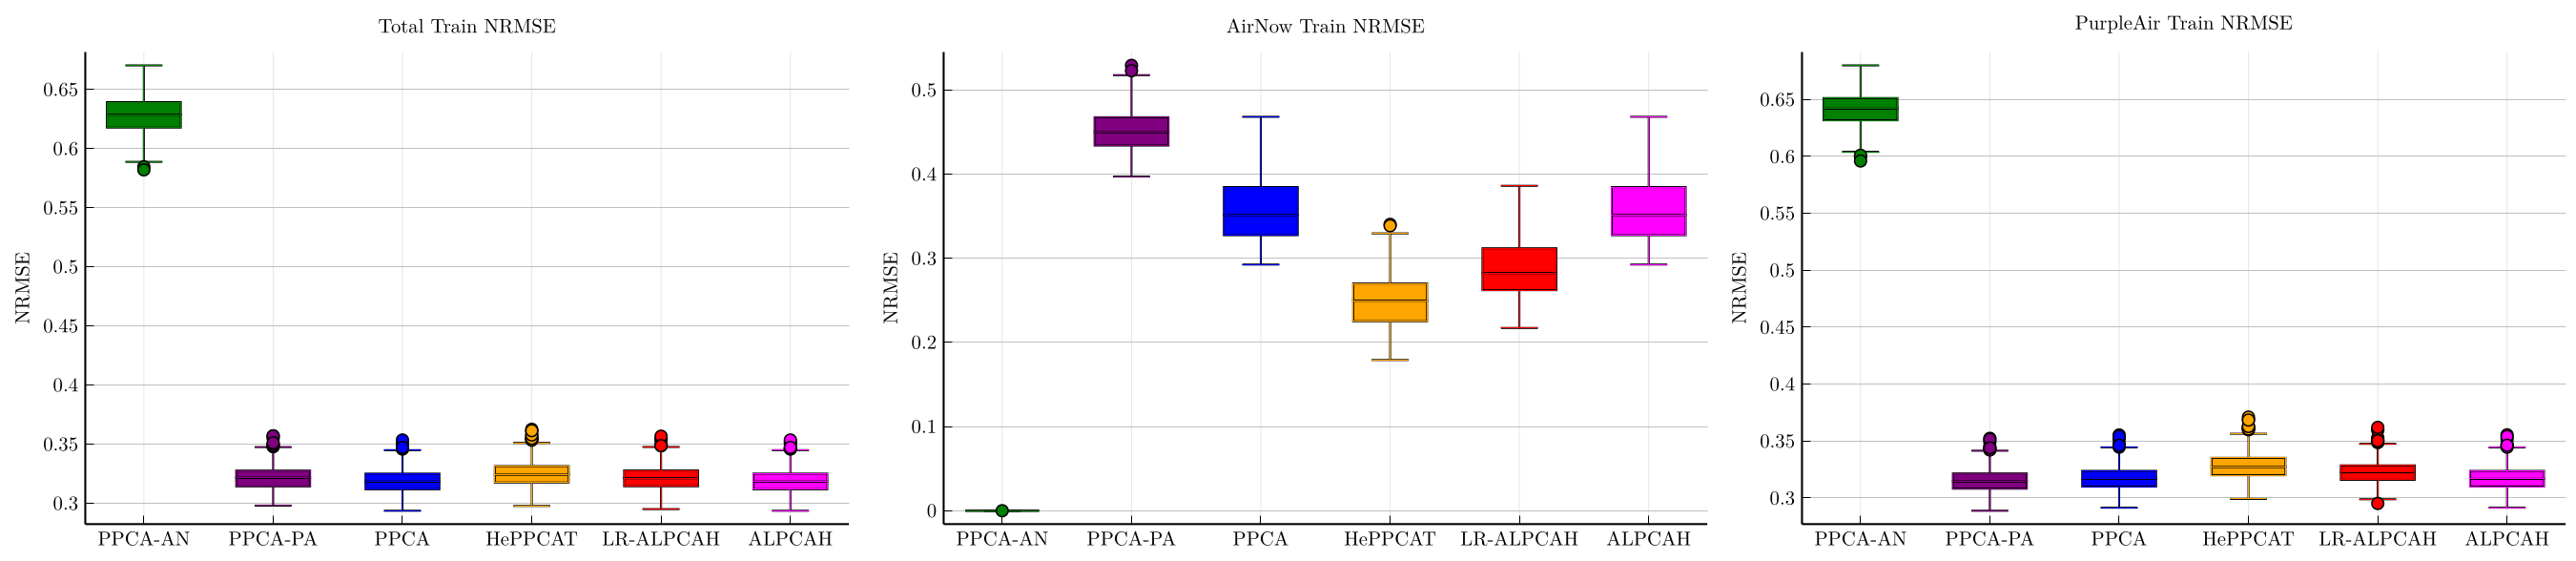

In [13]:
pgfplotsx()
boxplots = []
titles = ["Total Train NRMSE","AirNow Train NRMSE","PurpleAir Train NRMSE"]
ylabels = ["NRMSE" "NRMSE" "NRMSE"]

for j=1:3
    p = plot(size=(500,300))
    p = boxplot(["PPCA-AN" "PPCA-PA" "PPCA" "HePPCAT" "LR-ALPCAH" "ALPCAH"], train_errors[:,j,:]', leg = false,title=titles[j],color=[:green :purple :blue :orange :red :magenta],
        ylabel=ylabels[j], yticks = :native)
#     p = ylims!((0,0.4))
    push!(boxplots,p)  
end

plot_boxes = plot(boxplots...,layout=(1,3),size=(1800,400),left_margin = 0mm,
                    xtickfont=font(10), 
                    ytickfont=font(10), 
                    guidefont=font(10), 
                    legendfont=font(10))
#savefig("train_results.svg")

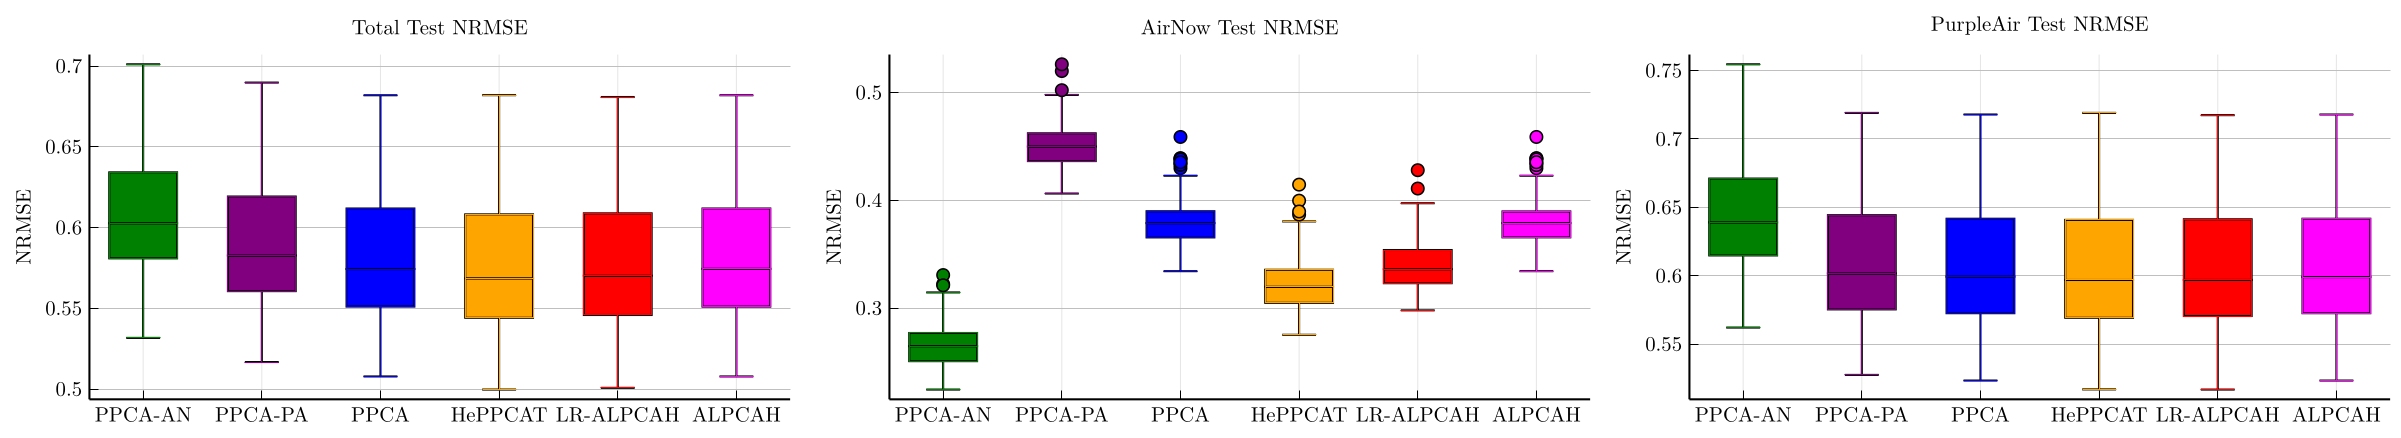

In [14]:
boxplots = []
titles = ["Total Test NRMSE","AirNow Test NRMSE","PurpleAir Test NRMSE"]
using StatsPlots

for j=1:3
    p = plot(size=(500,300))
    p = boxplot(["PPCA-AN" "PPCA-PA" "PPCA" "HePPCAT" "LR-ALPCAH" "ALPCAH"], test_errors[:,j,:]', leg = false,title=titles[j],
        color=[:green :purple :blue :orange :red :magenta],ylabel="NRMSE",yticks = :native)
#     p = ylims!((0,0.4))
    push!(boxplots,p)  
end

plot_boxes = plot(boxplots...,layout=(1,3),size=(1600,300),left_margin=0mm,
                    xtickfont=font(10), 
                    ytickfont=font(10), 
                    guidefont=font(10), 
                    legendfont=font(10))
#savefig("test_results.svg")

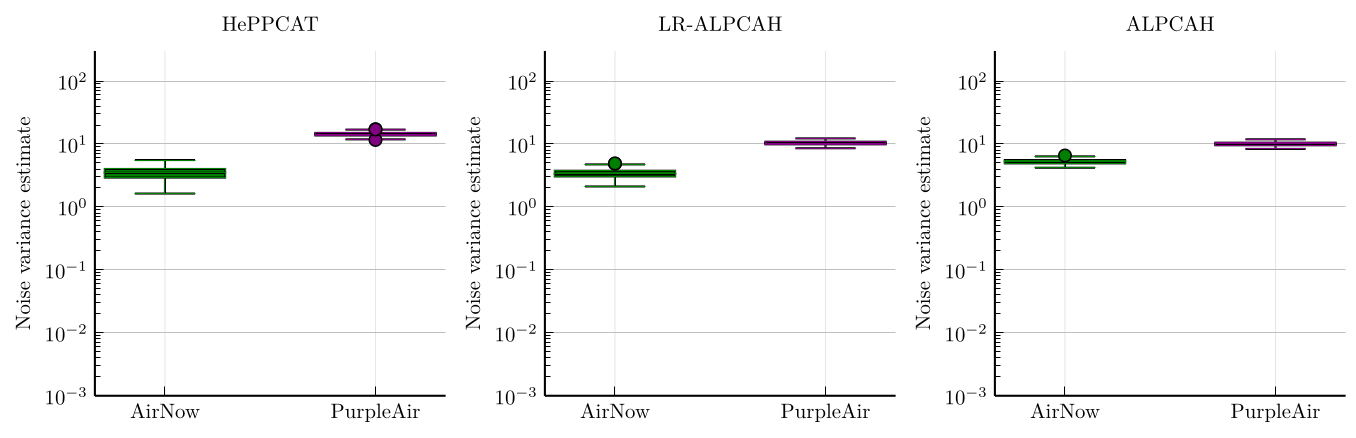

In [15]:
boxplots = []
titles = ["HePPCAT","LR-ALPCAH","ALPCAH"]
using StatsPlots

for j=1:3
    p = plot(size=(300,300))
    p = boxplot(["AirNow" "PurpleAir"], variances[j,:,:]', leg = false,title=titles[j],color=[:green :purple],ylabel="Noise variance estimate",
        ylims=(0.001,300),yaxis=:log,yticks = :native)
#     p = ylims!((0,0.4))
    push!(boxplots,p)  
end

plot_boxes = plot(boxplots...,layout=(1,3),size=(900,300),left_margin=0mm,
                    xtickfont=font(10), 
                    ytickfont=font(10), 
                    guidefont=font(10), 
                    legendfont=font(10))
#savefig("variance_results.svg")